# Wedges in `bruges`

Let's make wedge models!

We're going to make **all sorts of models** using one magical function. Here's what it can do:

- Layer-cake models with no dip.
- Wedge models with arbitrary thickness on the left and right.
- Clinoform models.
- Models filled with arbitrary stratigraphy, from constant values to well logs.

All these models can have varying amounts of rock above and below them, and can be extended left and right beyond the wedgy part. You can also dip the wedge in either direction.

**This is a new feature introduced in v0.4.2; if you find bugs, please let us know by [raising an issue](https://github.com/agile-geoscience/bruges/issues).**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import bruges as bg

---

## The default model and a basic synthetic workflow

We can produce a simple wedge model just by calling the function.

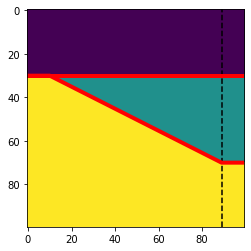

In [2]:
w, top, base, ref = bg.models.wedge()

plt.imshow(w, interpolation='none')
plt.axvline(ref, color='k', ls='--')
plt.plot(top, 'r-', lw=4)
plt.plot(base, 'r-', lw=4)
plt.show()

You can then use this integer model to index into an array of rock properties:

In [3]:
rocks = np.array([2.32 * 2.65,  # Rock index 0
                  2.35 * 2.60,  # Rock index 1
                  2.35 * 2.62,  # Rock index 2
                 ])

# Fancy indexing into the rocks with the model.
impedance = rocks[w]

# Make reflectivity.
rc = (impedance[1:] - impedance[:-1]) / (impedance[1:] + impedance[:-1])

# Get a wavelet.
ricker, _ = bg.filters.ricker(0.064, 0.001, 40, sym=True, return_t=True)

# Repeated 1D convolution for a synthetic.
syn = np.apply_along_axis(np.convolve, arr=rc, axis=0, v=ricker, mode='same')

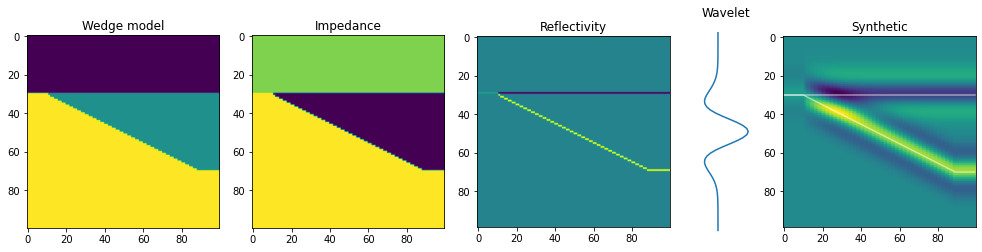

In [4]:
fig, axs = plt.subplots(figsize=(17, 4), ncols=5, gridspec_kw={'width_ratios': (4, 4, 4, 1, 4)})
axs[0].imshow(w)
axs[0].set_title('Wedge model')
axs[1].imshow(impedance)
axs[1].set_title('Impedance')
axs[2].imshow(rc)
axs[2].set_title('Reflectivity')
axs[3].plot(ricker, np.arange(ricker.size))
axs[3].axis('off')
axs[3].set_title('Wavelet')
axs[4].imshow(syn)
axs[4].set_title('Synthetic')
axs[4].plot(top, 'w', alpha=0.5)
axs[4].plot(base, 'w', alpha=0.5)
plt.show()

Note that we could also have made the impedance model directly — it just depends how you want to make your models. 

So we can use the `strat` argument, and pass in the rock properties there. 

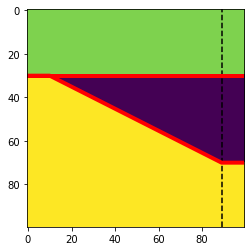

In [5]:
w, top, base, ref = bg.models.wedge(strat=rocks)

plt.imshow(w, interpolation='none')
plt.axvline(ref, color='k', ls='--')
plt.plot(top, 'r-', lw=4)
plt.plot(base, 'r-', lw=4)
plt.show()

Now the wedge contains rock properties, not integer labels.

In [6]:
w[:, 50]

array([6.148, 6.148, 6.148, 6.148, 6.148, 6.148, 6.148, 6.148, 6.148,
       6.148, 6.148, 6.148, 6.148, 6.148, 6.148, 6.148, 6.148, 6.148,
       6.148, 6.148, 6.148, 6.148, 6.148, 6.148, 6.148, 6.148, 6.148,
       6.148, 6.148, 6.148, 6.11 , 6.11 , 6.11 , 6.11 , 6.11 , 6.11 ,
       6.11 , 6.11 , 6.11 , 6.11 , 6.11 , 6.11 , 6.11 , 6.11 , 6.11 ,
       6.11 , 6.11 , 6.11 , 6.11 , 6.11 , 6.11 , 6.157, 6.157, 6.157,
       6.157, 6.157, 6.157, 6.157, 6.157, 6.157, 6.157, 6.157, 6.157,
       6.157, 6.157, 6.157, 6.157, 6.157, 6.157, 6.157, 6.157, 6.157,
       6.157, 6.157, 6.157, 6.157, 6.157, 6.157, 6.157, 6.157, 6.157,
       6.157, 6.157, 6.157, 6.157, 6.157, 6.157, 6.157, 6.157, 6.157,
       6.157, 6.157, 6.157, 6.157, 6.157, 6.157, 6.157, 6.157, 6.157,
       6.157])

---

## A layered wedge model

We can modify the stratigraphy of any layer. E.g., let's pass `(1, 2, 1, 2, 1)` in as the wedge strat, instead of just `1`. We'll also change the bottom layer to a `3`, so now we have 4 rocks.

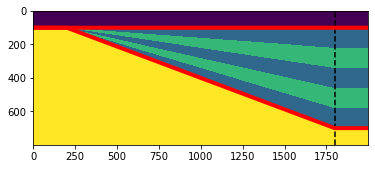

In [7]:
w, top, base, ref = bg.models.wedge(depth=(100, 600, 100),
                                    width=(200, 1600, 200),
                                    strat=(0, (1, 2, 1, 2, 1), 3),
                                    mode='linear'
                                   )

plt.imshow(w, interpolation='none')
plt.axvline(ref, color='k', ls='--')
plt.plot(top, 'r-', lw=4)
plt.plot(base, 'r-', lw=4)
plt.show()

Notice that the `wedge` function returns 4 things:

- The wedge model as a 2D NumPy array of ints (or whatever numbers you gave as input).
- The top horizon, in pixel index units, for convenience.
- The base horizon, in pixel index units, for convenience.
- The horizontal (left-right) position, as an integer, of the 'reference' model. You may or may not be interested in this, depending on your application.

If you only want the wedge, you can call the function like so:

    wedge, *_ = bg.models.wedge()

---

## Arbitrary thicknesses

You can provide the minimum and maximum thickness of the wedge.

**Note:** If the maximum thickness of the wedge if more than 1, then the total depth (i.e. number of rows) of the model will be more than the sum of the `depth` argument, so that the entire model can be accommodated. If you don't want the 'extra' depth, you can slice them off the model as with any NumPy array.

Here's a layer cake:

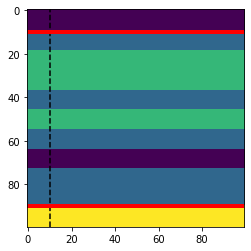

In [8]:
w, top, base, ref = bg.models.wedge(depth=(10., 80, 10),
                          width=(10, 80, 10),
                          strat=(0, (1, 2, 2, 1, 2, 1, 0, 1, 1,), 3),  # Floats in the wedge
                          thickness=(1, 1),
                          mode='linear',
                         )

plt.imshow(w, interpolation='none')
plt.axvline(ref, color='k', ls='--')
plt.plot(top, 'r-', lw=4)
plt.plot(base, 'r-', lw=4)
plt.show()

Here's another example. This time we'll also pass in floats — velocities perhaps.

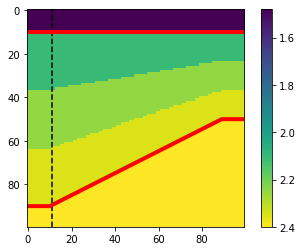

In [9]:
w, top, base, ref = bg.models.wedge(depth=(10., 80, 10),
                          width=(10, 80, 10),
                          strat=(1.48, (2.10, 2.25, 2.35), 2.40),  # Floats in the wedge.
                          thickness=(1, 0.5),
                          mode='linear',
                         )

plt.imshow(w, interpolation='none')
plt.axvline(ref, color='k', ls='--')
plt.plot(top, 'r-', lw=4)
plt.plot(base, 'r-', lw=4)
cb = plt.colorbar()
cb.ax.invert_yaxis()
plt.show()

---

## Top and bottom conformance

The layers in the wedge can also be top or bottom conforming, rather than proportionally adjusted.

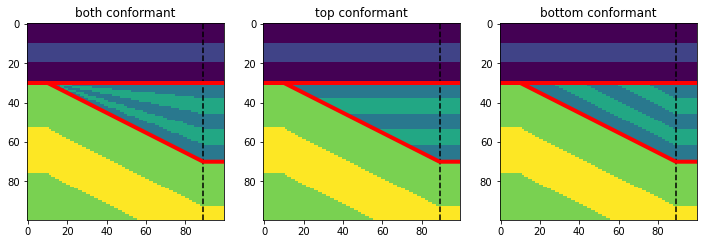

In [10]:
confs = ['both', 'top', 'bottom']

fig, axs = plt.subplots(ncols=len(confs), figsize=(12, 4))
for ax, conf in zip(axs, confs):
    w, top, base, ref = bg.models.wedge(strat=((0, 1, 0), (2, 3, 2, 3, 2), (4, 5, 4)),
                                        conformance=conf)
    ax.imshow(w, interpolation='none')
    ax.axvline(ref, color='k', ls='--')
    ax.plot(top, 'r-', lw=4)
    ax.plot(base, 'r-', lw=4)
    ax.set_title(f"{conf} conformant")
plt.show()

---

## Different 'wedge' shapes

The linear wedge is familiar, but you can also have other shapes (`power` and `root` were new in v0.4.3):

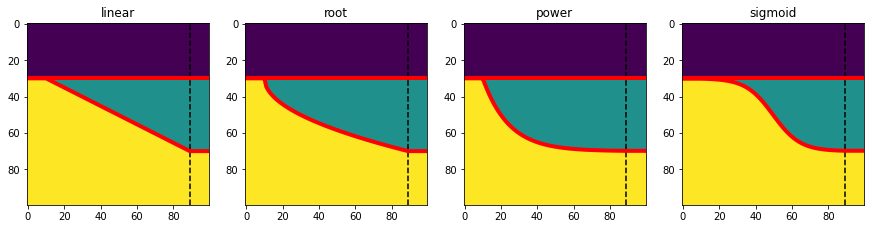

In [11]:
modes = ['linear', 'root', 'power', 'sigmoid']

fig, axs = plt.subplots(ncols=len(modes), figsize=(15, 5))
for ax, mode in zip(axs, modes):
    w, top, base, ref = bg.models.wedge(mode=mode)
    ax.imshow(w, interpolation='none')
    ax.axvline(ref, color='k', ls='--')
    ax.plot(top, 'r-', lw=4)
    ax.plot(base, 'r-', lw=4)
    ax.set_title(mode)
plt.show()

If you're feeling creative, you can also give `wedge()` your own function (since version 0.4.3). Your function should have an API like `np.linspace()` (the function that produces the standard wedge shape). Here's an example:

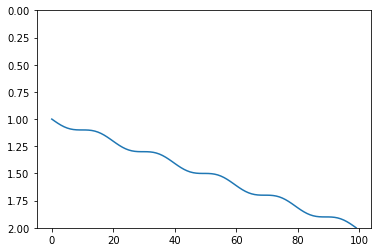

In [12]:
def wavy(start, stop, num):
    """
    Custom wedge shape.
    """
    x = np.linspace(0, 10*np.pi, num)
    y = np.sin(x) + x
    
    # Normalize to 0-1.
    y_ = (y - np.min(y)) / (np.max(y)-np.min(y))
    
    # Scale to required output.
    return min(start, stop) + abs(stop-start) * y_


# The wedge function will pass 'left' and 'right' thicknesses.
# You only need to worry about the case where left < right.
left, right = 1, 2
y = wavy(left, right, 100)

plt.plot(y)
plt.ylim(right, 0)
plt.show()

Let's use that function to make a model:

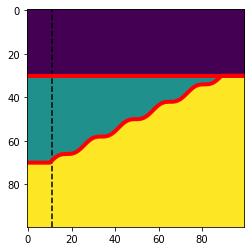

In [13]:
w, top, base, ref = bg.models.wedge(mode=wavy, thickness=(1, 0))

plt.imshow(w, interpolation='none')
plt.axvline(ref, color='k', ls='--')
plt.plot(top, 'r-', lw=4)
plt.plot(base, 'r-', lw=4)
plt.show()

---

## Varying net:gross across `breadth`

**This is a new feature introduced in v0.4.3; if you find bugs, please let us know by [raising an issue](https://github.com/agile-geoscience/bruges/issues).**

If you define a **binary wedge** — i.e. exactly 2 lithologies in the wedge layer — then you can pass a `breadth` argument to get a 3D model. The new dimension contains the 2 pure litholgies at each end, and pinches them out across the model's 'breadth'. Now the top and base are 2D arrays (surfaces through the wedge volume), while `ref` is still a scalar (the lateral position of the reference 'trace').

In [14]:
w, top, base, ref = bg.models.wedge(strat=(0, (1, 2, 1, 1, 2, 1), 3),  # Binary wedge.
                                    breadth=100)

w.shape, top.shape, base.shape, ref

((100, 100, 100), (100, 100), (100, 100), 89)

Let's look at 3 slices: one from one end of the 'net:gross' axis (the last axis), one from the other end (right hand image), and one from halfway (middle image). These are the net:gross end-members.

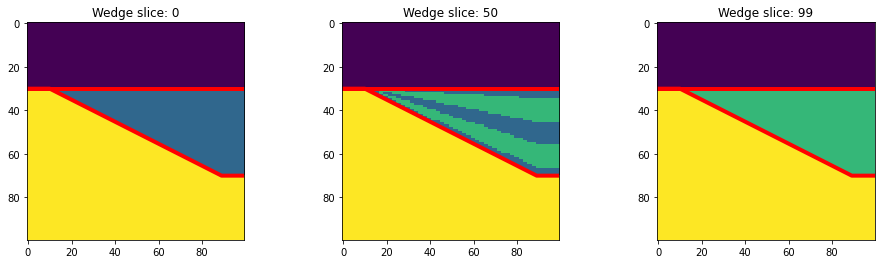

In [15]:
slices = [0, 50, 99]

fig, axs = plt.subplots(ncols=len(slices), figsize=(16, 4))
for ax, slic in zip(axs, slices):
    ax.imshow(w[..., slic], interpolation='none')
    ax.plot(top[:, slic], 'r-', lw=4)
    ax.plot(base[:, slic], 'r-', lw=4)
    ax.set_title(f"Wedge slice: {slic}")
plt.show()

Slices in/out of the page, look like this:

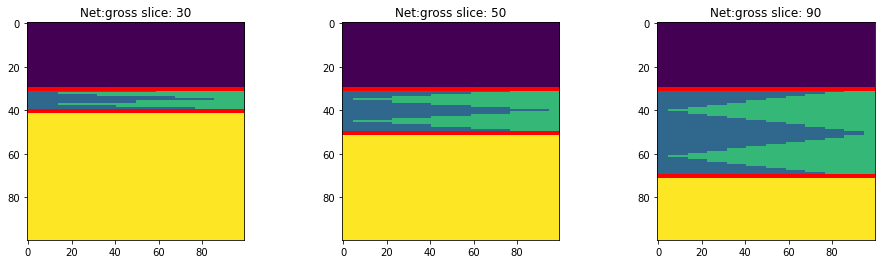

In [16]:
slices = [30, 50, 90]

fig, axs = plt.subplots(ncols=len(slices), figsize=(16, 4))
for ax, slic in zip(axs, slices):
    ax.imshow(w[:, slic], interpolation='none')
    ax.plot(top[slic], 'r-', lw=4)
    ax.plot(base[slic], 'r-', lw=4)
    ax.set_title(f"Net:gross slice: {slic}")
plt.show()

Let's simulate the seismic:

In [17]:
rocks = np.array([2.32 * 2.65,  # Rock index 0
                  2.35 * 2.60,  # Rock index 1
                  2.35 * 2.62,  # Rock index 2
                  2.37 * 2.61,  # Rock index 3
                 ])

impedance = rocks[w]
rc = (impedance[1:] - impedance[:-1]) / (impedance[1:] + impedance[:-1])
syn_ = [np.apply_along_axis(np.convolve, arr=line, axis=0, v=ricker, mode='same')
        for line in np.moveaxis(rc, 1, 0)]
syn = np.moveaxis(syn_, 0, 1)
syn.shape

(99, 100, 100)

Let's look at the three orthognal profiles through this synthetic:

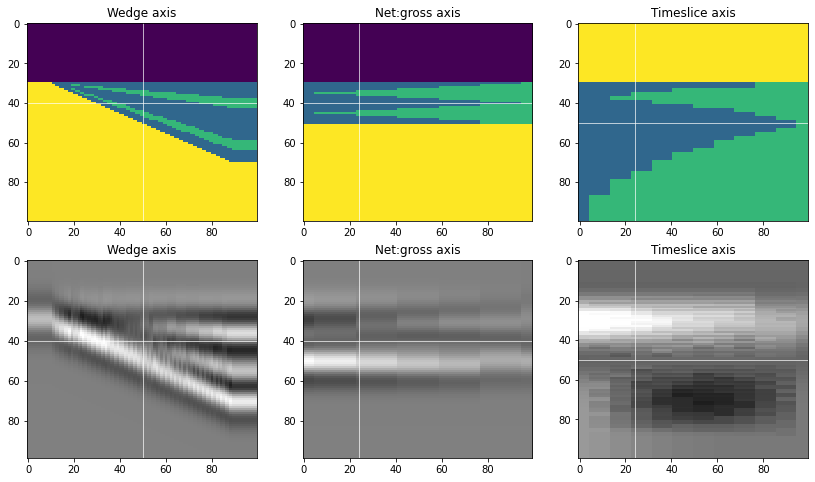

In [18]:
ma = np.percentile(syn, 99.9)
vols, cmaps = [w, syn], ['viridis', 'gray']

fig, axs = plt.subplots(ncols=3, nrows=2, figsize=(14, 8))
for row, vol, cm in zip(axs, vols, cmaps):
    row[0].imshow(vol[:, :, 24], aspect='auto', interpolation='none', cmap=cm, vmin=-ma if vol is syn else None, vmax=ma if vol is syn else None)
    row[0].axhline(40, c='w', lw=0.67)
    row[0].axvline(50, c='w', lw=0.67)
    row[0].set_title(f"Wedge axis")
    row[1].imshow(vol[:, 50, :], aspect='auto', interpolation='none', cmap=cm, vmin=-ma if vol is syn else None, vmax=ma if vol is syn else None)
    row[1].axhline(40, c='w', lw=0.67)
    row[1].axvline(24, c='w', lw=0.67)
    row[1].set_title(f"Net:gross axis")
    row[2].imshow(vol[40, :, :], aspect='auto', interpolation='none', cmap=cm, vmin=0 if vol is w else -ma, vmax=ma if vol is syn else None)
    row[2].axhline(50, c='w', lw=0.67)
    row[2].axvline(24, c='w', lw=0.67)
    row[2].set_title(f"Timeslice axis")
plt.show()

---

## Models from well logs

We can pass in arrays as `strat` and they will be used as the values in the model layers.

We'll start by loading a CSV file of a well log and dissecting it into three zones that we can pass in as `strat`. [Welly](https://code.agilescientific.com/welly/) would but useful for this, but we can also select these segments using conditions on the key depth boundaries.

In [104]:
log_data = np.loadtxt('../data/P-129.csv', delimiter=',', skiprows=1)
depths, impedance = log_data[:, 0], log_data[:, 4]

In [105]:
datum, top, base, floor = 500, 701, 805, 1005 

log_upper = impedance[(depths >= datum) & (depths < top)]
log_wedge = impedance[(depths >= top) & (depths < base)]
log_lower = impedance[(depths >= base) & (depths < floor)]

upper_depths = depths[(depths >= datum) & (depths < top)]
wedge_depths = depths[(depths >= top) & (depths < base)]
lower_depths = depths[(depths >= base) & (depths < floor)]

A quick plot of the three zones shows us the stratigraphic inputs to the `wedge` function.

(1005.0, 500.0)

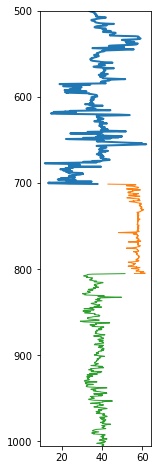

In [108]:
plt.figure(figsize=(2, 8))
plt.plot(log_upper, upper_depths, lw=2)
plt.plot(log_wedge, wedge_depths, lw=1)
plt.plot(log_lower, lower_depths, lw=1)
plt.ylim(floor, datum)

The middle piece (orange) will be fitted to the middle layer of the wedge (resulting in the number of pixels given in the `depth` argument. The upper (blue) and lower (green) pieces will then be cropped to fit their layers, so you must provide enough data for this to happen. The safest thing to do is to provide the _entire_ log above and the same below.

Now we can send these pieces to `wedge`; it will squeeze all of `log_wedge` into the 104 pixels allotted to the wedge layer in `depth`. But it will only use the bits of `log_above` and `log_below` that it needs for the 200 pixels above and the 205 below (adjusting for the scale implied by the wedge). We've chosen the depth interval for each layer to equal the length of each log segment in metres. This is not required however, it simply prevents distorting the individual segments at the reference trace.

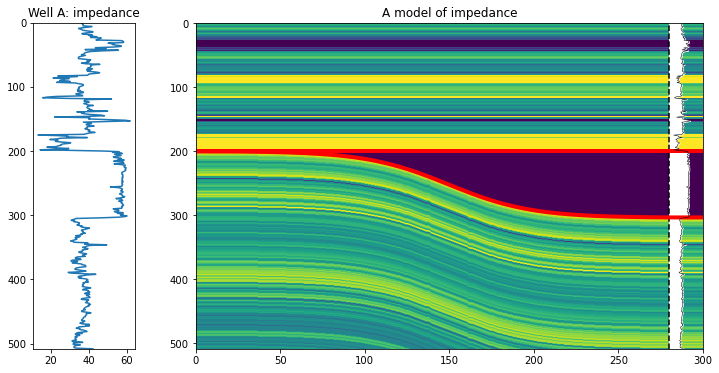

In [109]:
w, top, base, ref = bg.models.wedge(depth=(200, 104, 205),
                         width=(20, 260, 20), 
                         strat=(log_upper[:-1], log_wedge[1:], log_lower[1:]),
                         mode='sigmoid', conformance='bottom',
                         thickness=(0, 1)
                        )
ref = 280
datum = upper_depths[0]
log = w[:, ref]
depth = np.arange(len(log))
fig, axs = plt.subplots(figsize=(12, 6), ncols=2, gridspec_kw={'width_ratios': (1, 5)})
axs[0].plot(log, depth)
axs[0].set_ylim(depth[-1], depth[0])
axs[0].set_title('Well A: impedance')


im=axs[1].imshow(w, aspect='auto', cmap='viridis_r', vmin=30, vmax=50)
axs[1].axvline(ref, color='k', ls='--')
axs[1].plot(top, 'r-', lw=4)
axs[1].plot(base, 'r-', lw=4)
axs[1].fill_betweenx(depth, 2*(log/10) + ref, ref, color='w', alpha=1.0)
axs[1].plot(2*(log/10) + ref, depth, c='k', lw=0.5)
axs[1].set_title('A model of impedance')
axs[1].set_xlim(0, 300)
plt.show()

---
&copy; 2021 Agile Scientific, licensed CC-BY / Apache 2.0